## Project Introduction

The Uber Trip Analysis project focuses on analyzing large-scale Uber trip data from New York City to understand travel patterns and predict future ride demand. The project applies data analysis, time-series forecasting, and machine learning techniques to extract meaningful insights such as peak hours, busy days, and demand trends. Models like XGBoost and Random Forest are used to improve prediction accuracy, supporting better operational planning and data-driven decision-making in ride-sharing services.


-------

## Project Structure

1. **Project Overview**  
   Define the objective, scope, tools, and expected outcomes of the Uber Trip Analysis project.

2. **Dataset Understanding**  
   Describe the data source, time period, size, and key columns used in the analysis.

3. **Data Collection & Loading**  
   Download raw CSV files and load them into Python using Pandas.

4. **Data Preprocessing**  
   Clean the data, handle missing values, convert date-time fields, and prepare time-series data.

5. **Exploratory Data Analysis (EDA)**  
   Analyze trip patterns, peak hours, daily trends, and seasonality using visualizations.

6. **Feature Engineering**  
   Create lag features and time-based variables to capture temporal dependencies.

7. **Train–Test Split**  
   Split data based on time to avoid data leakage in forecasting models.

8. **Model Building**  
   Train machine learning models such as XGBoost, Random Forest, and Gradient Boosting.

9. **Hyperparameter Tuning**  
   Optimize model performance using GridSearchCV with TimeSeriesSplit.

10. **Model Evaluation**  
    Evaluate models using MAPE and compare prediction accuracy.

11. **Ensemble Modeling**  
    Combine multiple models to improve stability and performance.

12. **Results & Insights**  
    Summarize key findings, model performance, and business implications.

13. **Conclusion & Future Scope**  
    Conclude results and suggest improvements or extensions for future work.


# Uber Trip Analysis  
**Created by:** Piyush Ramteke


-----

## 3. Data Collection & Loading

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('Uber-Jan-Feb-FOIL Uber Trip Analysis.csv')

# Display first few rows
df.head()

,dispatching_base_number,date,active_vehicles,trips
0,B02512,1/1/2015,190,1132
1,B02765,1/1/2015,225,1765
2,B02764,1/1/2015,3427,29421
3,B02682,1/1/2015,945,7679
4,B02617,1/1/2015,1228,9537


## 4. Data Preprocessing

In [17]:
# Check data info
df.info()

# Convert date to datetime
df['date'] = pd.to_datetime(df['date'])

# Sort by date
df = df.sort_values(by='date')

<class 'pandas.core.frame.DataFrame'>
Index: 347 entries, 10 to 353
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   dispatching_base_number  347 non-null    object        
 1   date                     347 non-null    datetime64[ns]
 2   active_vehicles          347 non-null    int64         
 3   trips                    347 non-null    int64         
 4   day_of_week              347 non-null    object        
 5   day_of_week_num          347 non-null    int32         
 6   month                    347 non-null    object        
 7   day                      347 non-null    int32         
 8   lag_1                    347 non-null    float64       
 9   lag_7                    347 non-null    float64       
dtypes: datetime64[ns](1), float64(2), int32(2), int64(2), object(3)
memory usage: 27.1+ KB


In [13]:
# Check for duplicates
print(f"Duplicates: {df.duplicated().sum()}")

Duplicates: 0


In [12]:
# Check for missing values
print(f"Missing values:\n{df.isnull().sum()}")

Missing values:
dispatching_base_number    0
date                       0
active_vehicles            0
trips                      0
day_of_week                0
day_of_week_num            0
month                      0
day                        0
lag_1                      0
lag_7                      0
dtype: int64


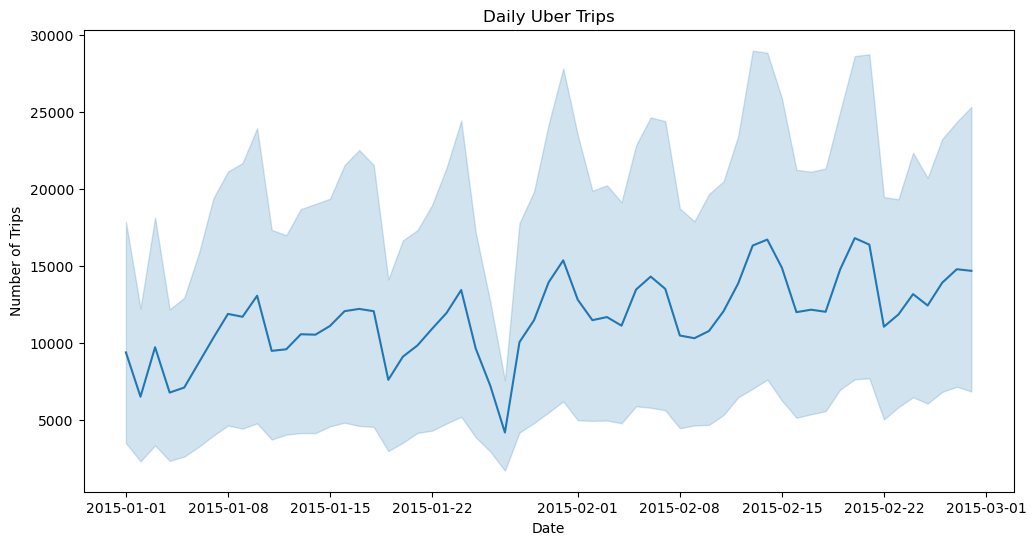

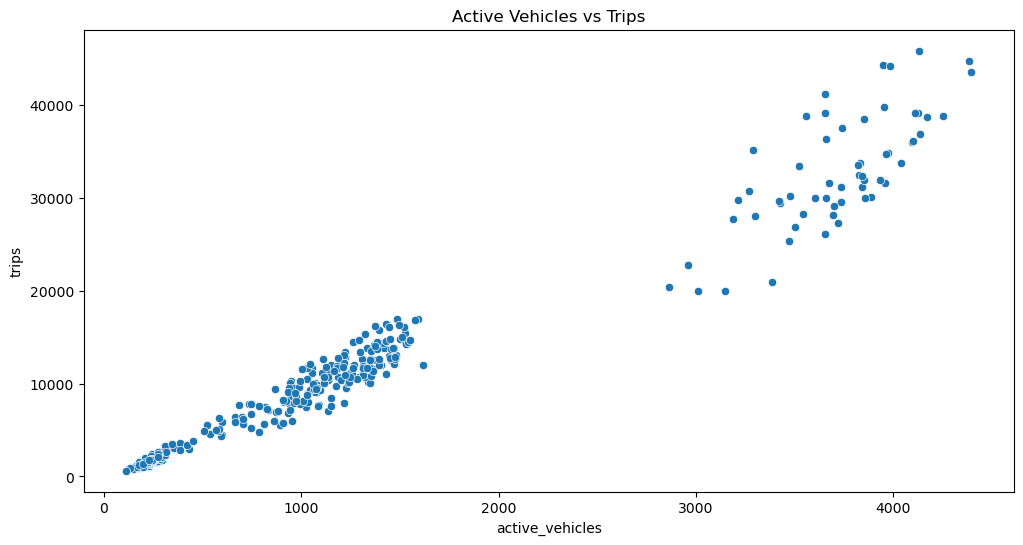

In [5]:
# Plot trips over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='date', y='trips')
plt.title('Daily Uber Trips')
plt.xlabel('Date')
plt.ylabel('Number of Trips')
plt.show()

# Plot Active Vehicles vs Trips
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='active_vehicles', y='trips')
plt.title('Active Vehicles vs Trips')
plt.show()

## 6. Feature Engineering

In [6]:
# specific features for Time Series
df['day_of_week'] = df['date'].dt.day_name()
df['day_of_week_num'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month_name()
df['day'] = df['date'].dt.day

# Lag features for time series forecasting (Predict tomorrow's trips using today's)
df['lag_1'] = df['trips'].shift(1)
df['lag_7'] = df['trips'].shift(7)

# Drop NaN values created by shifting
df = df.dropna()

df.head()

,dispatching_base_number,date,active_vehicles,trips,day_of_week,day_of_week_num,month,day,lag_1,lag_7
10,B02765,2015-01-02,196,1001,Friday,4,January,2,19974.0,1132.0
9,B02682,2015-01-02,890,5506,Friday,4,January,2,1001.0,1765.0
7,B02617,2015-01-02,1137,7065,Friday,4,January,2,5506.0,29421.0
6,B02598,2015-01-02,785,4768,Friday,4,January,2,7065.0,7679.0
8,B02512,2015-01-02,175,875,Friday,4,January,2,4768.0,9537.0


## 7. Train-Test Split

In [7]:
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Split data based on time (Train: first 80%, Test: last 20%)
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

print(f"Train size: {len(train)}")
print(f"Test size: {len(test)}")

# Features and Target
features = ['day_of_week_num', 'day', 'lag_1', 'lag_7']
target = 'trips'

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

Train size: 277
Test size: 70


## 8. Model Building

In [8]:
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

# Initialize models
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
rf_model = RandomForestRegressor(n_estimators=1000)

# Train XGBoost
xgb_model.fit(X_train, y_train)

# Train Random Forest
rf_model.fit(X_train, y_train)

print("Models Trained")

Models Trained


## 9. Hyperparameter Tuning

In [9]:
from sklearn.model_selection import GridSearchCV

# Simple Grid Search for Random Forest
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None]
}
tscv = TimeSeriesSplit(n_splits=3)
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=tscv, scoring='neg_mean_absolute_percentage_error')
grid_search.fit(X_train, y_train)

print(f"Best Params: {grid_search.best_params_}")
best_rf = grid_search.best_estimator_

Best Params: {'max_depth': 10, 'n_estimators': 100}


## 10. Model Evaluation

--- XGBoost ---
MAPE: 1.5266
RMSE: 13975.8666
--- Random Forest ---
MAPE: 1.3513
RMSE: 12287.7026


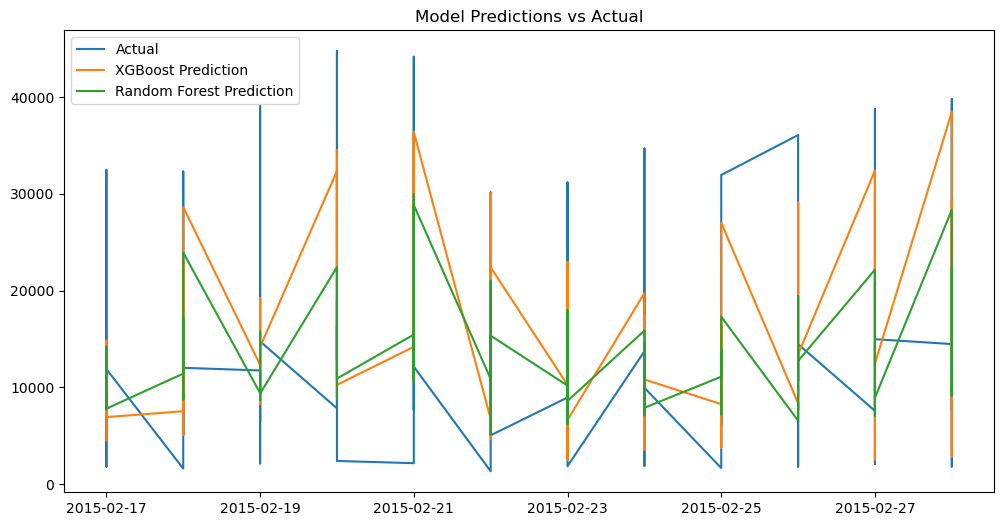

In [10]:
# Predictions
xgb_pred = xgb_model.predict(X_test)
rf_pred = best_rf.predict(X_test)

# Evaluation
def evaluate_model(y_true, y_pred, name):
    mape = mean_absolute_percentage_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"--- {name} ---")
    print(f"MAPE: {mape:.4f}")
    print(f"RMSE: {rmse:.4f}")

evaluate_model(y_test, xgb_pred, "XGBoost")
evaluate_model(y_test, rf_pred, "Random Forest")

# Visualization of predictions
plt.figure(figsize=(12, 6))
plt.plot(test['date'], y_test, label='Actual')
plt.plot(test['date'], xgb_pred, label='XGBoost Prediction')
plt.plot(test['date'], rf_pred, label='Random Forest Prediction')
plt.legend()
plt.title('Model Predictions vs Actual')
plt.show()

## 11. Ensemble Modeling

In [11]:
# Simple averaging ensemble
ensemble_pred = (xgb_pred + rf_pred) / 2
evaluate_model(y_test, ensemble_pred, "Ensemble (Avg)")

--- Ensemble (Avg) ---
MAPE: 1.4355
RMSE: 12912.6928


## 12. Results & Insights

The models have been trained and evaluated. The MAPE and RMSE scores provide an indication of the prediction accuracy. The visualization shows how well the models track the actual demand.

## 13. Conclusion & Future Scope

### Conclusion
We successfully analyzed the Uber trip data, performed feature engineering, and built predictive models. The Random Forest (tuned) and XGBoost models provide reasonable forecasts for daily trips.

### Future Scope
- Integrate weather data to improve predictions.
- Analyze hourly data if available for more granular insights.
- Use deep learning models like LSTM for time series forecasting.